# PS4-1: Neural Networks: MNIST Image Classification

## Import Library

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Global Parameters

In [83]:
MAX_POOL_SIZE = 5
CONVOLUTION_SIZE = 4
CONVOLUTION_FILTERS = 2

## Training NN Algorithm

### Model Architcture

In [84]:
def forward_softmax(x):
    """
    Compute softmax function for a single example.
    The shape of the input is of size # num classes.

    Important Note: You must be careful to avoid overflow for this function. Functions
    like softmax have a tendency to overflow when very large numbers like e^10000 are computed.
    You will know that your function is overflow resistent when it can handle input like:
    np.array([[10000, 10010, 10]]) without issues.

        x: A 1d numpy float array of shape number_of_classes

    Returns:
        A 1d numpy float array containing the softmax results of shape  number_of_classes
    """
    x = x - np.max(x,axis=0)
    exp = np.exp(x)
    s = exp / np.sum(exp,axis=0)
    return s

In [85]:
def backward_softmax(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x.

    grad_outputs is the gradient of the loss with respect to the outputs of the softmax.

    Args:
        x: A 1d numpy float array of shape number_of_classes
        grad_outputs: A 1d numpy float array of shape number_of_classes

    Returns:
        A 1d numpy float array of the same shape as x with the derivative of the loss with respect to x
    """

    # *** START CODE HERE ***
    """
    We need to compute derivative of CE loss w.r.t x
    Note: x = logits (input of softmax) => x is 1D, y_hat = softmax(x)
    Formula: dCE/dx = dCE/dy_hat * dy_hat/dx (Chain Rule), where:
        dCE/dy_hat = grad_outputs
        dy_hat/dx = Derivative of y_hat w.r.t x
    """
    # 1. Get x size = number_of_classes
    K = len(x)

    # 2. Calculate Softmax
    y_hat = forward_softmax(x)

    # 3. Update dCE/dx
    d_CE_x = np.zeros(K)

    for j in range(K):
        for k in range(K):
            if j == k:
                d_CE_x[j] += grad_outputs[k] * y_hat[k] * (1 - y_hat[k])
            else:
                d_CE_x[j] += grad_outputs[k] * (- y_hat[k] * y_hat[j])

    return d_CE_x
    # *** END CODE HERE ***

In [86]:
def forward_relu(x):
    """
    Compute the relu function for the input x.

    Args:
        x: A numpy float array

    Returns:
        A numpy float array containing the relu results
    """
    x[x<=0] = 0

    return x

In [87]:
def backward_relu(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x

    Args:
        x: A numpy array of arbitrary shape containing the input.
        grad_outputs: A numpy array of the same shape of x containing the gradient of the loss with respect
            to the output of relu

    Returns:
        A numpy array of the same shape as x containing the gradients with respect to x.
    """

    # *** START CODE HERE ***
    """
    We need to compute derivative of "Cross-Entropy Loss is calculated after Softmax" loss w.r.t x
    Note: x = MaxPooling output (input of ReLU) => x is 3D image (Batch Size, Channels, Heights, Widths)
    Formula: dL/dx = dL/reLU * dreLU/dx (Chain Rule), where:
        dL/dreLU = grad_outputs
        dreLU/dx  = Derivative of reLU w.r.t x
    """
    # 1. Get x shape
    C, H, W = x.shape

    # 2. Update dL/dreLU
    grad_x = np.zeros(x.shape)
    for c in range(C):
        for h in range(H):
            for w in range(W):
                if x[c, h, w] > 0:
                    grad_x[c, h, w] = 1 * grad_outputs[c, h, w]
                else:
                    grad_x[c, h, w] = 0

    return grad_x
    # *** END CODE HERE ***

In [88]:
def get_initial_params():
    """
    Compute the initial parameters for the neural network.

    This function should return a dictionary mapping parameter names to numpy arrays containing
    the initial values for those parameters.

    There should be four parameters for this model:
    W1 is the weight matrix for the convolutional layer
    b1 is the bias vector for the convolutional layer
    W2 is the weight matrix for the output layers
    b2 is the bias vector for the output layer

    Weight matrices should be initialized with values drawn from a random normal distribution.
    The mean of that distribution should be 0.
    The variance of that distribution should be 1/sqrt(n) where n is the number of neurons that
    feed into an output for that layer.

    Bias vectors should be initialized with zero.


    Returns:
        A dict mapping parameter names to numpy arrays
    """

    size_after_convolution = 28 - CONVOLUTION_SIZE + 1
    size_after_max_pooling = size_after_convolution // MAX_POOL_SIZE

    num_hidden = size_after_max_pooling * size_after_max_pooling * CONVOLUTION_FILTERS

    return {
        'W1': np.random.normal(size = (CONVOLUTION_FILTERS, 1, CONVOLUTION_SIZE, CONVOLUTION_SIZE), scale=1/ math.sqrt(CONVOLUTION_SIZE * CONVOLUTION_SIZE)),
        'b1': np.zeros(CONVOLUTION_FILTERS),
        'W2': np.random.normal(size = (num_hidden, 10), scale = 1/ math.sqrt(num_hidden)),
        'b2': np.zeros(10)
    }

In [89]:
def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.

    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)

    data is of the shape (# input channels, width, height)

    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)

    Returns:
        The output of the convolution as a numpy array
    """
    """
    Parameters:
    oc = output_channels
    ic = input_channels
    x = starting coordinates in width.
    y = starting coordinates in height.
    di = conv_W_offset_width
    dj = conv_W_offset_height
    data = input data

    Formula:
    output[oc, x, y] = conv_b[oc] + sum_di,sum_dj,sum_ic (data[ic, x + di, y + dj] * conv_W[oc, ic, di, dj])
    """
    conv_channels, _, conv_width, conv_height = conv_W.shape

    input_channels, input_width, input_height = data.shape

    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))

    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]

    return output

In [90]:
def backward_convolution(conv_W, conv_b, data, output_grad):
    """
    Compute the gradient of the loss with respect to the parameters of the convolution.

    See forward_convolution for the sizes of the arguments.
    output_grad is the gradient of the loss with respect to the output of the convolution.

    Returns:
        A tuple containing 3 gradients.
        The first element is the gradient of the loss with respect to the convolution weights
        The second element is the gradient of the loss with respect to the convolution bias
        The third element is the gradient of the loss with respect to the input data
    """

    # *** START CODE HERE ***
    """
    We need to compute derivative of "Loss Function" loss w.r.t conv_W, conv_b, data in tuple

    Parameters:
    oc = output_channels
    ic = input_channels
    x = starting coordinates in width (data)
    y = starting coordinates in height (data)
    di = conv_W_offset_width
    dj = conv_W_offset_height
    data = input data

    Formula:
    dL/doutput = dL/doutput[oc, x, y] === output_grad

    doutput/dconv_W = doutput[oc, x, y]/dconv_W[oc, ic, di, dj] === data[ic, x + di, y + dj]

    doutput/dconv_b = doutput[oc, x, y]/dconv_b[oc] === 1

    doutput/ddata = doutput[oc, x, y]/ddata[ic, x+di, y+dj] === conv_W[oc, ic, di, dj]

    So, we have full Formula:
    1. dL/dconv_W = dL/doutput * doutput/dconv_W === sum_x,sum_y (output_grad[oc, x, y] * data[ic, x + di, y + dj])

    2. dL/dconv_b = dL/doutput * doutput/dconv_b === sum_x, sum_y (output_grad[oc, x, y] * 1)

    3. dL/ddata = dL/doutput * doutput/ddata === sum_oc, sum_di, sum_dj (output_grad[oc, x-di, y-dj] * conv_W[oc, ic, di, dj])
    """
    # 1. Get Parameters
    conv_channels, _, conv_width, conv_height = conv_W.shape
    input_channels, input_width, input_height = data.shape
    _, output_width, output_height = output_grad.shape

    # 2. Initialize Gradient
    dW = np.zeros(conv_W.shape)
    db = np.zeros(conv_b.shape)
    ddata = np.zeros(data.shape)

    # 3. dL/dconv_W
    for oc in range(conv_channels):
        for ic in range(input_channels):
            for di in range(conv_width):
                for dj in range(conv_height):
                    temp_grad = 0
                    for x in range(output_width):
                        for y in range(output_height):
                            temp_grad += output_grad[oc, x, y] * data[ic, x + di, y + dj]
                    dW[oc, ic, di, dj] = temp_grad

    # 4. dL/dconv_b
    for oc in range(conv_channels):
        temp_grad = 0
        for x in range(output_width):
            for y in range(output_height):
                temp_grad += output_grad[oc, x, y] * 1
        db[oc] = temp_grad

    # 5. dL/ddata
    for oc in range(conv_channels):
        for ic in range(input_channels):
            for x in range(input_width):
                for y in range(input_height):
                    temp_grad = 0
                    for di in range(conv_width):
                        for dj in range(conv_height):
                            x_out = x - di
                            y_out = y - dj
                            if 0 <= x_out < output_width and 0 <= y_out < output_height:
                                temp_grad += output_grad[oc, x_out, y_out] * conv_W[oc, ic, di, dj]
                    ddata[ic, x, y] = temp_grad

    return dW, db, ddata
    # *** END CODE HERE ***

In [91]:
def forward_max_pool(data, pool_width, pool_height):
    """
    Compute the output from a max pooling layer given the data and pool dimensions.

    The stride length should be equal to the pool size

    data is of the shape (# channels, width, height)

    The output should be the result of the max pooling layer and should be of size:
        (# channels, width // pool_width, height // pool_height)

    Returns:
        The result of the max pooling layer
    """
    """
    Parameters:
    oc = output_channels
    ic = input_channels
    x = starting coordinates in width (data)
    y = starting coordinates in height (data)
    di = conv_W_offset_width
    dj = conv_W_offset_height
    data = input data

    Formula:
    output[oc, x, y] = max_di,dj (data[ic, x * pool_width + di, y * pool_height + dj])
    """
    input_channels, input_width, input_height = data.shape

    output = np.zeros((input_channels, input_width // pool_width, input_height // pool_height))

    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):

            output[:, x // pool_width, y // pool_height] = np.amax(data[:, x:(x + pool_width), y:(y + pool_height)], axis=(1, 2))

    return output

In [92]:
def backward_max_pool(data, pool_width, pool_height, output_grad):
    """
    Compute the gradient of the loss with respect to the data in the max pooling layer.

    data is of the shape (# channels, width, height)
    output_grad is of shape (# channels, width // pool_width, height // pool_height)

    output_grad is the gradient of the loss with respect to the output of the backward max
    pool layer.

    Returns:
        The gradient of the loss with respect to the data (of same shape as data)
    """

    # *** START CODE HERE ***
    """
    We need to compute derivative of "Loss Function" loss w.r.t data

    Parameters:
    oc = output_channels
    ic = input_channels
    x = starting coordinates in width (data)
    y = starting coordinates in height (data)
    di = step of pool_width
    dj = step of pool_height
    data = input data
    x_out = x/pool_width
    y_out = y/pool_height

    Formula:
    dL/doutput = dL/doutput[oc, x, y] === output_grad[oc, x_out, y_out]

    doutput/ddata = doutput[oc, x, y]/ddata[ic, x * pool_width + di, y * pool_height + dj] === 1 (if (i,j) is max in (x_out, y_out)) else === 0

    So, we have ful Formula:
    dL/ddata = dL/doutput * doutput/ddata === output_grad[oc, x_out, y_out] * 1 (if (i,j) is max in (x_out, y_out)) or === 0
    """
    # 1. Get Parameters
    input_channels, input_width, input_height = data.shape
    X_out, Y_out = input_width // pool_width, input_height // pool_height
    _, output_width, output_height = output_grad.shape

    # 2. Initialize Parameters
    ddata = np.zeros(data.shape)

    # 3. dL/ddata
    for ic in range(input_channels):
        for x_out in range(X_out):
            for y_out in range(Y_out):
                max_i, max_j = 0, 0
                max_value = -1e9
                for di in range(pool_width):
                    for dj in range(pool_height):
                        val = data[ic, x_out * pool_width + di, y_out * pool_height + dj]
                        if val > max_value:
                            max_value = 1 * val
                            max_i, max_j = di, dj
                ddata[ic, x_out * pool_width + max_i, y_out * pool_height + max_j] = output_grad[ic, x_out, y_out]          #oc = ic

    return ddata
    # *** END CODE HERE ***

In [93]:
def forward_cross_entropy_loss(probabilities, labels):
    """
    Compute the output from a cross entropy loss layer given the probabilities and labels.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be a scalar

    Returns:
        The result of the log loss layer
    """

    result = 0

    for i, label in enumerate(labels):
        if label == 1:
            result += -np.log(probabilities[i])

    return result

In [94]:
def backward_cross_entropy_loss(probabilities, labels):
    """
    Compute the gradient of the cross entropy loss with respect to the probabilities.

    probabilities is of the shape (# classes)
    labels is of the shape (# classes)

    The output should be the gradient with respect to the probabilities.

    Returns:
        The gradient of the loss with respect to the probabilities.
    """

    # *** START CODE HERE ***
    """
    We need to estimate Derivative of CE Loss w.r.t y_hat_k (probabilities)

    Formula:
    dCE/dy_hat_k = -y_k/y_hat_k
    With "one-hot-labels"   => dCE/dy_hat_k = -1/y_hat_k = -1/probabilities[k]
                            => dCE/dy_hat_k = 0
    """
    # 1. Get labels size
    K = len(labels)

    # 2. Initialize gradient
    grad = np.zeros(K)

    # 3. dCE/dx_k
    for k in range(K):
        if labels[k] == 1:
            grad[k] = -1.0 / probabilities[k]
        else:
            grad[k] = 0.0

    return grad
    # *** END CODE HERE ***

In [95]:
def forward_linear(weights, bias, data):
    """
    Compute the output from a linear layer with the given weights, bias and data.
    weights is of the shape (input # features, output # features)
    bias is of the shape (output # features)
    data is of the shape (input # features)

    The output should be of the shape (output # features)

    Returns:
        The result of the linear layer
    """
    return data.dot(weights) + bias

In [96]:
def backward_linear(weights, bias, data, output_grad):
    """
    Compute the gradients of the loss with respect to the parameters of a linear layer.

    See forward_linear for information about the shapes of the variables.

    output_grad is the gradient of the loss with respect to the output of this layer.

    This should return a tuple with three elements:
    - The gradient of the loss with respect to the weights
    - The gradient of the loss with respect to the bias
    - The gradient of the loss with respect to the data
    """

    # *** START CODE HERE ***
    """
    We need to estimate "Loss Function" w.r.t weights, bias, data

    Parameters:
    weights = 2D (input_features, output_features)
    bias = 1D (output_features)
    data = 1D (input_features)

    Formula:
    Linear = x.W + b

    dL/dLinear = output_grad
    dL/dweights = dL/dLinear * dLinear/dweights === output_grad * data
    dL/dbias = dL/dLinear * dLinear/dbias === output_grad * 1
    dL/ddata = dL/dLinear * dLinear/ddata === output_grad * weights
    """
    # 1. Get weights shape
    input_features, output_features = weights.shape

    # 2. Initialize gradients
    dweights = np.zeros(weights.shape)
    dbias = np.zeros(bias.shape)
    ddata = np.zeros(data.shape)

    # 3. dweights[i,j] = output_grad[j] * data[i]
    for i in range(input_features):
        for j in range(output_features):
            dweights[i, j] = output_grad[j] * data[i]

    # 4. dbias[j] = output_grad[j] * 1
    for j in range(output_features):
        dbias[j] = output_grad[j]

    # 5. ddata[i] = output_grad[j] * weights[i, j]
    for i in range(input_features):
        temp = 0
        for j in range(output_features):
            temp += output_grad[j] * weights[i, j]
        ddata[i] = temp

    return dweights, dbias, ddata
    # *** END CODE HERE ***

In [97]:
def forward_prop(data, labels, params):
    """
    Implement the forward layer given the data, labels, and params.

    Args:
        data: A numpy array containing the input (shape is 1 by 28 by 28)
        labels: A 1d numpy array containing the labels (shape is 10)
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A 2 element tuple containing:
            1. A numpy array The output (after the softmax) of the output layer
            2. The average loss for these data elements
    """

    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)

    flattened = np.reshape(first_after_relu, (-1))

    logits = forward_linear(W2, b2, flattened)

    y = forward_softmax(logits)
    cost = forward_cross_entropy_loss(y, labels)

    return y, cost

In [98]:
def backward_prop(data, labels, params):
    """
    Implement the backward propagation gradient computation step for a neural network

    Args:
        data: A numpy array containing the input for a single example
        labels: A 1d numpy array containing the labels for a single example
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2, and b2
            W1 and b1 represent the weights and bias for the convolutional layer
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.

        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """

    # *** START CODE HERE ***
    # 1. Get Parameters
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    # 2. Forward to get cache value
    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)
    flattened = np.reshape(first_after_relu, (-1))
    logits = forward_linear(W2, b2, flattened) # Input of Softmax
    y = forward_softmax(logits)

    # 3. Backward CE
    grad_CE = backward_cross_entropy_loss(y, labels)   # dL/dy_hat

    # 4. Backward Softmax
    grad_sm = backward_softmax(logits, grad_CE)

    # 4. Backward Linear
    dW2, db2, dflattened = backward_linear(W2, b2, flattened, grad_sm)

    # 5. Backward Flatten to ReLU
    drelu = np.reshape(dflattened, first_after_relu.shape)
    drelu_back = backward_relu(first_max_pool, drelu)

    # 6. Backward Max Pooling
    dmaxpool = backward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE, drelu_back)

    # 7. Backward Convolution
    dW1, db1, _ = backward_convolution(W1, b1, data, dmaxpool)

    # 8. Return Results
    grads = {
        'W1': dW1,
        'b1': db1,
        'W2': dW2,
        'b2': db2
    }

    return grads
    # *** END CODE HERE ***

In [99]:
def forward_prop_batch(batch_data, batch_labels, params, forward_prop_func):
    """Apply the forward prop func to every image in a batch"""

    y_array = []
    cost_array = []

    for item, label in zip(batch_data, batch_labels):
        y, cost = forward_prop_func(item, label, params)
        y_array.append(y)
        cost_array.append(cost)

    return np.array(y_array), np.array(cost_array)

In [100]:
def gradient_descent_batch(batch_data, batch_labels, learning_rate, params, backward_prop_func):
    """
    Perform one batch of gradient descent on the given training data using the provided learning rate.

    This code should update the parameters stored in params.
    It should not return anything

    Args:
        batch_data: A numpy array containing the training data for the batch
        train_labels: A numpy array containing the training labels for the batch
        learning_rate: The learning rate
        params: A dict of parameter names to parameter values that should be updated.
        backward_prop_func: A function that follows the backwards_prop API

    Returns: This function returns nothing.
    """

    total_grad = {}

    for i in range(batch_data.shape[0]):
        grad = backward_prop_func(
            batch_data[i, :, :],
            batch_labels[i, :],
            params)
        for key, value in grad.items():
            if key not in total_grad:
                total_grad[key] = np.zeros(value.shape)

            total_grad[key] += value

    params['W1'] = params['W1'] - learning_rate * total_grad['W1']
    params['W2'] = params['W2'] - learning_rate * total_grad['W2']
    params['b1'] = params['b1'] - learning_rate * total_grad['b1']
    params['b2'] = params['b2'] - learning_rate * total_grad['b2']

    # This function does not return anything
    return

### Model Training Algorithm

In [101]:
def nn_train(
    train_data, train_labels, dev_data, dev_labels,
    get_initial_params_func, forward_prop_func, backward_prop_func,
    learning_rate=5.0, batch_size=16, num_batches=400):

    m = train_data.shape[0]

    params = get_initial_params_func()

    cost_dev = []
    accuracy_dev = []
    for batch in range(num_batches):
        print('Currently processing {} / {}'.format(batch, num_batches))

        batch_data = train_data[batch * batch_size:(batch + 1) * batch_size, :, :, :]
        batch_labels = train_labels[batch * batch_size: (batch + 1) * batch_size, :]

        if batch % 100 == 0:
            output, cost = forward_prop_batch(dev_data, dev_labels, params, forward_prop_func)
            cost_dev.append(sum(cost) / len(cost))
            accuracy_dev.append(compute_accuracy(output, dev_labels))

            print('Cost and accuracy', cost_dev[-1], accuracy_dev[-1])

        gradient_descent_batch(batch_data, batch_labels,
            learning_rate, params, backward_prop_func)

    return params, cost_dev, accuracy_dev

In [102]:
def nn_test(data, labels, params):
    output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

In [103]:
def compute_accuracy(output, labels):
    correct_output = np.argmax(output,axis=1)
    correct_labels = np.argmax(labels,axis=1)

    is_correct = [a == b for a,b in zip(correct_output, correct_labels)]

    accuracy = sum(is_correct) * 1. / labels.shape[0]
    return accuracy

In [104]:
def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

In [105]:
def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')

    x = np.reshape(x, (x.shape[0], 1, 28, 28))

    return x, y

In [106]:
def run_train(all_data, all_labels, backward_prop_func):
    params, cost_dev, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'],
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        learning_rate=1e-2, batch_size=16, num_batches=400
    )

    t = np.arange(400 // 100)

    fig, (ax1, ax2) = plt.subplots(2, 1)

    ax1.plot(t, cost_dev, 'b')
    ax1.set_xlabel('time')
    ax1.set_ylabel('loss')
    ax1.set_title('Training curve')

    ax2.plot(t, accuracy_dev, 'b')
    ax2.set_xlabel('time')
    ax2.set_ylabel('accuracy')

    fig.savefig('output/train.png')

### Training Model

In [107]:
def main():
    np.random.seed(100)
    train_data, train_labels = read_data('/home/anhnt02/Desktop/data_1/images_train.csv', '/home/anhnt02/Desktop/data_1/labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p,:]
    train_labels = train_labels[p,:]

    dev_data = train_data[0:400,:]
    dev_labels = train_labels[0:400,:]
    train_data = train_data[400:,:]
    train_labels = train_labels[400:,:]

    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std

    all_data = {
        'train': train_data,
        'dev': dev_data,
    }

    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
    }

    run_train(all_data, all_labels, backward_prop)

Currently processing 0 / 400
Cost and accuracy 2.721417647426753 0.0725
Currently processing 1 / 400
Currently processing 2 / 400
Currently processing 3 / 400
Currently processing 4 / 400
Currently processing 5 / 400
Currently processing 6 / 400
Currently processing 7 / 400
Currently processing 8 / 400
Currently processing 9 / 400
Currently processing 10 / 400
Currently processing 11 / 400
Currently processing 12 / 400
Currently processing 13 / 400
Currently processing 14 / 400
Currently processing 15 / 400
Currently processing 16 / 400
Currently processing 17 / 400
Currently processing 18 / 400
Currently processing 19 / 400
Currently processing 20 / 400
Currently processing 21 / 400
Currently processing 22 / 400
Currently processing 23 / 400
Currently processing 24 / 400
Currently processing 25 / 400
Currently processing 26 / 400
Currently processing 27 / 400
Currently processing 28 / 400
Currently processing 29 / 400
Currently processing 30 / 400
Currently processing 31 / 400
Current

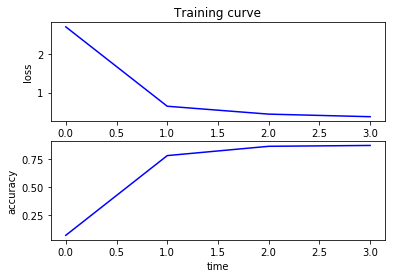

In [108]:
main()